# Cloning repo from GitHub

In [ ]:
%reset -f 

In [ ]:
!rm -rf nst_imaginenet
!git clone https://github.com/gohar-malik/nst-imaginenet nst_imaginenet

Cloning into 'nst_imaginenet'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 136 (delta 16), reused 3 (delta 1), pack-reused 102
Receiving objects: 100% (136/136), 5.95 MiB | 22.01 MiB/s, done.
Resolving deltas: 100% (55/55), done.


# Importing Dependies

In [ ]:
import copy
import time
import PIL
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from torch.autograd import Variable

from nst_imaginenet import app_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Preparing the Model
I use VGG-19 as the base model, like in both the papers NST and ImagineNet. The model is modified in the following way:
* Renames the layers of VGG to match the names used in both the papers
* Replaces MAxPool2d with AvgPool2d
* Replaces ReLU with a custom made ReLU function with accessible outputs

In [ ]:
# The ReLUs in the original VGG will be replaced by this function
# It just adds a self.output variable to store the output of the method
class ReLU_output(nn.ReLU):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.output = 0
    def forward(self, input):
        self.output = F.relu(input, inplace=self.inplace)
        return self.output

# This function modifies the original VGG-19 and renames its layers
def modify_vgg(model):
  block, number = 1, 1
  renamed = nn.Sequential()
  for layer in model.children():
    if isinstance(layer, nn.Conv2d):
      name = f'conv{block}_{number}'
    elif isinstance(layer, nn.ReLU):
      name = f'relu{block}_{number}'
      layer = ReLU_output(inplace=False)
      number += 1
    elif isinstance(layer, nn.MaxPool2d):
      name = f'pool_{block}'
      layer = nn.AvgPool2d(layer.kernel_size, layer.stride)
      block += 1
      number = 1
    else:
      raise RuntimeError(f'Unrecognized layer "{layer.__class__.__name__}""') 
    renamed.add_module(name, layer)
  return renamed.to(device)

In [ ]:
model = models.vgg19(pretrained=True).features.to(device).eval()
model = modify_vgg(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
model

Sequential(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU_output()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU_output()
  (pool_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU_output()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU_output()
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU_output()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU_output()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU_output()
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_4): ReLU_output()
  (pool_3): Av

# Defining Losses
We defined the following three losses as nn.Module:
* Content Loss (Simply to maintain the content of the content image).
* Style Loss (To transfer the style from the style, called as the "Texture Component" in ImagineNet paper).
* Structure Loss (To ensure that the output image has similar cross covariance as the style image, From the ImagineNet paper).

I use the "Mean Squared Error Loss".

In [ ]:
class ContentLoss(nn.Module):

  def __init__(self, target):
    """
    Initializes a new ContentLoss instance.
    target: Pass the feature map of the content image from the specified 
            layer as the target.
    """
    super().__init__()
    self._target = target.detach()
    self.loss = None

  def forward(self, input):
    self.loss = F.mse_loss(input, self._target)
    return input


class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    """
    Initializes a new StyleLoss instance.
    target: Pass the feature map of the style image from the specified 
            layer as the target_feature.
    """
    super().__init__()
    self._target = self._gram_matrix(target_feature.detach()).detach()
    self.loss = None

  def _gram_matrix(self, input):
    """Returns the Gram matrix of the input."""
    n, c, w, h = input.size()
    features = input.view(n * c, w * h)
    G = torch.mm(features, features.t())
    # return G.div(n * c * w * h)
    return G

  def forward(self, input):
    G = self._gram_matrix(input)
    self.loss = F.mse_loss(G, self._target)
    return input

class StructureLoss(nn.Module):

  def __init__(self, target_feature1, target_feature2):
    """
    Initializes a new StructureLoss instance.
    The structure loss uses feature maps from two different layers to calculate
    the cross covariance matrix.
    target_features: Pass the feature maps of the style image from the specified 
            layers as the target_feature1 and targett_feature2.
    """
    super().__init__()
    self._target = self._covariance_matrix(target_feature1.detach(), 
                                           target_feature2.detach()).detach()
    self.loss = None

  def _covariance_matrix(self, input1, input2):
    """Returns the cross covariance matrix of the input."""
    input1 = F.interpolate(input1.unsqueeze(0), 
                           size = [input2.size()[1], input1.size()[2], input1.size()[3]]).squeeze(0)
    input2 = F.interpolate(input2, size = [input1.size()[2], input1.size()[3]])
    
    n, c, w, h = input1.size()

    features1 = input1.view(n * c, w * h)
    features2 = input2.view(n * c, w * h)
    G = torch.mm(features1, features2.t())
    # return G.div(n * c * w * h)
    return G

  def forward(self, input1, input2):
    G = self._covariance_matrix(input1, input2)
    self.loss = F.mse_loss(G, self._target)
    return self.loss

# Defining Functions


### Building a new nn.Sequential model to include losses
This block modifies our model to inlclude the normalization step and the Losses required for successful Style Transfer.

In [ ]:
class Normalize(nn.Module):
  """Module which normalizes inputs using the ImageNet mean and stddev."""

  def __init__(self):
    super().__init__()
    self._transform = transforms.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

  def forward(self, input):
    return self._transform(input.squeeze(0)).unsqueeze(0)

def get_nst_model_and_losses(
model,  content_img,  style_img, content_layers, style_layers, structure_layers):
  """Creates the Neural Style Transfer model and losses. 
  Args:
    model: The model to use for Neural Style Transfer. ContentLoss and StyleLoss
      modules will be inserted after each layer in content_layers and 
      style_layers respectively.
    content_img: The content image to use when creating the ContentLosses.
    style_img: The style image to use when creating the StyleLosses.
    content_layers: The name of the layers after which a ContentLoss module will
      be inserted.
    style_layers: The name of the layers after which a StyleLoss module will be
      inserted.
    structure_layers: The name of the layers that will be used for calculating 
      style loss
  Returns: 
    The NST model with ContentLoss and StyleLoss modules inserted
    The ContentLosses modules 
    The StyleLosses modules
    A dictionary contaning features maps of style image form the structure loss
      layers
    A dictionary containing the ReLU_output modules from which the input_image
      feature maps will be extarcted.
  """
  struct_layers = []
  # Splitting every pair of layers and saving them in struct_layers
  for string in structure_layers:
    struct_layers.extend(string.split(',', 1)) 
    
  # Making a dictionary to store style image feature maps from the layers
  # defined by the keys
  style_feature_dict = dict.fromkeys(struct_layers)
  # Making a dictionary to store ReLU_output modules from the layers
  # defined by the keys
  input_feature_dict = dict.fromkeys(struct_layers)

  nst_model = nn.Sequential(Normalize())
  content_losses, style_losses, last_layer = [], [], 0

  for i, (name, layer) in enumerate(copy.deepcopy(model).named_children()):
    nst_model.add_module(name, layer)

    # Inserting the ContentLoss Module after every layer in content_layers
    if name in content_layers:
      content_loss = ContentLoss(nst_model(content_img))
      nst_model.add_module(f'{name}_ContentLoss', content_loss)
      content_losses.append(content_loss)
      last_layer = i

    if name in style_layers or name in style_feature_dict.keys():
      # style_feature = nst_model(style_img)
      
      # Inserting the StyleLoss Module after every layer in content_layers
      if name in style_layers:
        style_loss = StyleLoss(nst_model(style_img))
        nst_model.add_module(f'{name}_StyleLoss', style_loss)
        style_losses.append(style_loss)
  
      if name in style_feature_dict.keys():
        # Saving the feature maps of style image in a dict
        style_feature_dict[name] = nst_model(style_img)
        # Saving the ReLU_output modules in a dict
        input_feature_dict[name] = layer
      last_layer = i

  # Sanity check that we have the desired number of style, structure and content layers.
  assert len(content_losses) == len(content_layers), 'Not all content layers found.'
  assert len(style_losses) == len(style_layers), 'Not all style layers found.'
  # assert len(style_feature_dict) == len(struct_layers), 'Not all structure layers found.'

  # Remove the layers after the last StyleLoss and ContentLoss since they will
  # not be used for style transfer.
  last_layer += 1 + len(content_losses) + len(style_losses)
  nst_model = nst_model[:last_layer+1].to(device)
  # print(nst_model)
  return nst_model, content_losses, style_losses, style_feature_dict, input_feature_dict

### The Optimization Function
This function is responsible for running the actual optimization to produce the output image.

In [ ]:
def run_style_transfer(
    model, 
    content_img, 
    style_img, 
    content_layers,
    style_layers,
    structure_layers,
    input_img=None,
    optmzr = 'adam', 
    num_steps=800, 
    content_weights=[5.6], 
    style_weights=[1.1, 1.3, 0.5, 1.0],
    structure_weights=[1.5, 1.5, 1.5, 1.5],
    tv_weight = 150,
    log_steps=50):
  """
  Args:
    model: The Neural Style Transfer model to use.
    content_image: The image whose content to match during the optimization. 
    style_image: The image whose style to match during the optimization.
    content_layers: The names of the layers whose output will be used to compute
      the content losses.
    style_layers: The names of the layers whose output will be used to compute
      the style losses.
    structure_layers: The names of the layers whose output will be used to compute
      the structure losses.
    input_img: The image which will be optimized to match the content and style
      of the content_img and style_img respectively. If None, defaults to random
      Gaussian noise.
    num_steps: The number of steps to run the optimization for.
    content_weights: An array of weights to multiply the content losses by. This 
      array should be in the same order as content_layers
    style_weights: An array of weights to multiply the style losses by. This 
      array should be in the same order as style_layers
    structure_weights: An array of weights to multiply the structure losses by. 
      This array should be in the same order as structures_layers 
    log_steps: The number of consecutive training steps to run before logging.
  Returns:
    The optimized input_img.
  """
  n, c, h, w = content_img.data.size()
  if input_img is None:
    input_img = torch.randn((n, c, h, w), device=device)
    input_img = input_img * .01 

  model, content_losses, style_losses, style_feature_dict, input_feature_dict = get_nst_model_and_losses(
      model, content_img, style_img, content_layers, style_layers, structure_layers)
  
  if optmzr == 'adam':
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.001)
  elif optmzr == 'lbfgs':
    optimizer = optim.LBFGS([input_img.requires_grad_()])

  mse_loss = torch.nn.MSELoss()
  # Making a list of the StructureLoss Modules
  structure_modules = []
  for string in (structure_layers):
    two_layers = string.split(',', 1)
    structure_modules.append(StructureLoss(style_feature_dict[two_layers[0]], 
                                           style_feature_dict[two_layers[1]]))

  step = [0]
  while step[0] <= num_steps:
    def closure():
      optimizer.zero_grad()
      input_img.data.clamp_(0, 1)

      # model(transform(input_img))
      model(input_img)

      content_loss, style_loss, structure_loss, tv_loss = 0, 0, 0, 0
      
      ############################ Content and Style Loss #######################
      for i, cl in enumerate(content_losses):
        content_loss += content_weights[i] * cl.loss
      for j, sl in enumerate(style_losses):
        style_loss += style_weights[j] * sl.loss

      ############################## Structure Loss ###########################
      structure_loss = 0
      for itr, str_module in enumerate(structure_modules):
        two_layers = structure_layers[itr].split(',', 1)
        structure_loss += structure_weights[itr] * str_module(
            input_feature_dict[two_layers[0]].output, input_feature_dict[two_layers[1]].output)

      ############################## Total Variational Loss ###########################
      assert input_img.data.size() == content_img.data.size(), 'Input Image != Content Image'
      h_tv = torch.pow((input_img[:, :, 1:, :] - input_img[:, :, :(h - 1), :]), 2).sum()
      w_tv = torch.pow((input_img[:, :, :, 1:] - input_img[:, :, :, :(w - 1)]), 2).sum()
      tv_loss = tv_weight * (h_tv + w_tv)
      ###########################################################################
    
    
      loss = content_loss + style_loss + structure_loss + tv_loss
      loss.backward()
      # optimizer.step()
      step[0] += 1

      if (step[0] % log_steps == 0) or ((step[0] + 1) == num_steps) or (step[0] in range(1,11)):
        print(f'[{step}]: Content loss={content_loss.item()},'
              f' Style loss={style_loss.item():4f},'
              f' Structure loss={structure_loss.item():4f},'
              f' T.V loss={tv_loss.item():4f},'
              f' Total loss={loss.item():4f}')
      return style_loss + content_loss + structure_loss + tv_loss
    optimizer.step(closure)

  app_utils.imshow(input_img.data.clamp_(0, 1), figsize=(10, 10))
      
    # return style_loss + content_loss + cam_loss

  return input_img

# Running the Algorithm (Finally!)


Uploading the Content Image

In [ ]:
# Please specify a single file
content = app_utils.upload_file()
!ls /tmp

Saving Berlin-Museum-Island.jpg to Berlin-Museum-Island.jpg
Berlin-Museum-Island.jpg
dap_multiplexer.81398e635059.root.log.INFO.20220505-134828.56
dap_multiplexer.INFO
debugger_2a4aqkr6u1
initgoogle_syslog_dir.0
pyright-110-3wE3uxxKymVc
pyright-110-ovEXFFLUPVxW
python-languageserver-cancellation


Uploading the Style Image

In [ ]:
# Please specify a single file
style = app_utils.upload_file()
!ls /tmp

Saving the_scream_2k.jpg to the_scream_2k.jpg
Berlin-Museum-Island.jpg
dap_multiplexer.81398e635059.root.log.INFO.20220505-134828.56
dap_multiplexer.INFO
debugger_2a4aqkr6u1
initgoogle_syslog_dir.0
pyright-110-3wE3uxxKymVc
pyright-110-ovEXFFLUPVxW
python-languageserver-cancellation
the_scream_2k.jpg


Loading the images

torch.Size([1, 3, 575, 1024])
torch.Size([1, 3, 575, 1024])


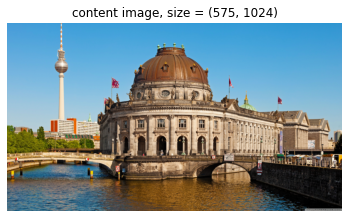

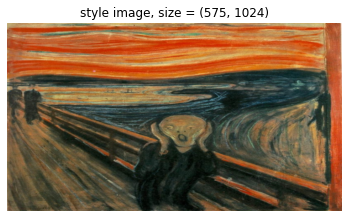

In [ ]:
# "cap" argument in the "load_image" function defines the upper bound on the input
# image. If an image is bigger than this, it is downscaled to this size.
content_img = app_utils.load_image("/tmp/" + content, cap = 1024)
content_img = content_img.unsqueeze(0).to(device)
print(content_img.shape)

style_img = app_utils.load_image("/tmp/" + style, size= [content_img.size()[2], content_img.size()[3]])
style_img = style_img.unsqueeze(0).to(device)
print(style_img.shape)

app_utils.imshow(content_img, title= f"content image, size = ({content_img.size()[2]}, {content_img.size()[3]})")
app_utils.imshow(style_img, title= f"style image, size = ({style_img.size()[2]}, {style_img.size()[3]})")

Running the model

In [ ]:
# Defining layers for all three losses
# You can increase, decrease or change the specified layers, but make sure you 
# exactly follow the convention
# Specifically for structure layers:
#   every pair should be separated by a comma without any spaces and the first 
#   layer should come earlier in the network   
content_layers=['relu4_1']
style_layers=['relu1_1', 'relu2_1', 'relu3_1']
structure_layers=['relu1_1,relu1_2',
                  'relu1_1,relu2_1',
                  'relu2_1,relu3_1']

# Defining weights for all three losses (Selected as mentioned in ImagineNet paper)
# These should in the same order as the layer names arrays defined above
content_weights=[5.6]
style_weights=[1.1, 1.3, 1.0]
structure_weights=[1.5, 1.5, 1.5]
tv_weight = 150

assert len(content_layers) == len(content_weights), 'Content weights and Layers are unequal'
assert len(style_layers) == len(style_weights), 'Style weights and Layers are unequal'
assert len(structure_layers) == len(structure_weights), 'Structure weights and Layers are unequal'

# Uncomment one of the lines below to use as the input_img to optimize.
# input_img = None
input_img = content_img.clone()
# input_img = style_img.clone()

tic = time.clock()
output = run_style_transfer(
    model=model, 
    content_img=content_img, 
    style_img=style_img,
    content_layers=content_layers,
    style_layers=style_layers,
    structure_layers=structure_layers,
    input_img = input_img,
    optmzr = 'adam',
    num_steps=200,
    content_weights=content_weights, 
    style_weights=style_weights,
    structure_weights=structure_weights,
    tv_weight = tv_weight,
    log_steps=25)
toc = time.clock()
timetaken = toc - tic
print(f'Elapsed Time = {timetaken} seconds')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[[1]]: Content loss=0.0, Style loss=26180098048.000000, Structure loss=83591897088.000000, T.V loss=2457377.000000, Total loss=109774454784.000000
[[2]]: Content loss=0.002409324049949646, Style loss=25729564672.000000, Structure loss=81876500480.000000, T.V loss=2426165.500000, Total loss=107608489984.000000
[[3]]: Content loss=0.008811235427856445, Style loss=25289658368.000000, Structure loss=80209502208.000000, T.V loss=2395791.500000, Total loss=105501556736.000000
[[4]]: Content loss=0.018379446119070053, Style loss=24859752448.000000, Structure loss=78588084224.000000, T.V loss=2366222.500000, Total loss=103450206208.000000
[[5]]: Content loss=0.030511124059557915, Style loss=24439445504.000000, Structure loss=77010132992.000000, T.V loss=2337439.750000, Total loss=101451915264.000000
[[6]]: Content loss=0.04472528398036957, Style loss=24028479488.000000, Structure loss=75474223104.000000, T.V loss=2309413.500000, Total loss=99505012736.000000
[[7]]: Content loss=0.0607336312532

Saving the result

In [ ]:
save_pth = '/tmp/' + content.split('.')[0] + '_' + style.split('.')[0] + '.jpg'
app_utils.save_image(output, save_pth)
print('Saving to: ' + save_pth)

Saving to: /tmp/hoovertowernight_Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg


Downloading the result to your local disk

In [ ]:
from google.colab import files
files.download(save_pth) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>